In [1]:
%matplotlib inline
from matplotlib import pyplot as plt

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

import re
import numpy as np
import pandas as pd
import seaborn as sns

sns.set_style("darkgrid")
sns.set_context('notebook', font_scale=1.2)

from glob import glob
from sklearn import metrics
from tqdm import tqdm_notebook as tqdm

# Detection Accuracy
We load the parameters of each generated adversarial in `class_data`. Each row contains the parameters for the generation of an adversarial image and the result of its classification for a particular defending model. Hence we have a row for each (adv. image, defense model) couple.

We consider only **base_inception_model**, that is the baseline InceptionV3 model trained on ImageNet. We also add the following columns:
  - **IsModified**: whether the image is maliciously manipulated
  - **IsCorrectlyClassified**: whether the network predicts the *true label* of the image

In [2]:
class_data = pd.read_csv('../output_dir/all_classification.csv')
class_data = class_data[class_data['DefenseName'] == 'base_inception_model']
# for now, let's not consider random_noise as an attack..
# class_data = class_data[class_data['AttackName'] != 'random_noise']
class_data['IsModified'] = ~class_data['AttackName'].isin(('noop', 'random_noise'))
# class_data['IsModified'] = ~class_data['AttackName'].isin(('noop', ))
class_data['IsCorrectlyClassified'] = class_data['TrueLabel'] == class_data['PredictedLabel']
class_data.head()

,AttackName,IsTargeted,DefenseName,ImageId,PredictedLabel,TrueLabel,TargetClass,IsModified,IsCorrectlyClassified
5000,noop,False,base_inception_model,b3c384a2d1a391c0,631,631,456,False,True
5001,noop,False,base_inception_model,f5a2cf5c66d313fa,977,977,656,False,True
5002,fgsm,False,base_inception_model,5d8085ae68e07d72,864,709,643,True,False
5003,noop,False,base_inception_model,328d99215b19c8c7,806,806,926,False,True
5004,random_noise,False,base_inception_model,9876fe92d003c9d4,913,913,357,False,True


Then, we load in `score_data` all the scores obtained by applying our approach. We have a score for each (image, scoring scheme, feature layer) triplet.

In [43]:
score_files = glob('detection_results/*')
score_data = pd.DataFrame()
regex = re.compile(r'detection_results\/scores_(.*_pool)_(.*)_(l?d?w?knn)\.csv')
for score_file in tqdm(score_files):
    pool, feature, scoring = regex.search(score_file).groups()
    tmp = pd.read_csv(score_file, names=['AttackName', 'ImageURL', 'PredictedLabel', 'Score'])
    tmp['ScoringScheme'] = scoring
    tmp['Features'] = feature
    tmp['Pooling'] = pool
    score_data = score_data.append(tmp, ignore_index=True)

score_data['ImageId'] = score_data['ImageURL'].apply(lambda x: x[:-4])
assert len(score_data) == 5000 * 5 * 13 * 2 # 5000 images, 5 scoring schemes, 13 features, 2 pooling
score_data.sample(10)

,AttackName,ImageURL,PredictedLabel,Score,ScoringScheme,Features,Pooling,ImageId
471539,noop,bb03be3702584eeb.png,672,0.002957,ldwknn,mixed_6e,max_pool,bb03be3702584eeb
73513,step_target_class,6cc289dc7a8fce86.png,158,0.691780,dwknn,prelogits,avg_pool,6cc289dc7a8fce86
244878,iter_target_class,8d68931ba23fdeb7.png,800,0.000227,wknn,mixed_6a,max_pool,8d68931ba23fdeb7
302529,random_noise,a7151de51c2f1d0b.png,345,0.031986,ldwknn,mixed_7a,avg_pool,a7151de51c2f1d0b
120030,fgsm,d23fd2119c4f5dec.png,974,0.000000,lwknn,mixed_6c,max_pool,d23fd2119c4f5dec
360640,fgsm,d3aa8ee50458c020.png,891,0.000000,wknn,mixed_7b,max_pool,d3aa8ee50458c020
611797,noop,34a39905ce228160.png,769,0.000000,lwknn,mixed_7b,max_pool,34a39905ce228160
581696,noop,143c74a57326fd40.png,422,0.011000,knn,mixed_6a,avg_pool,143c74a57326fd40
177235,random_noise,a92e49d8bbdc2aae.png,533,0.053719,wknn,mixed_6c,avg_pool,a92e49d8bbdc2aae
133445,step_target_class,e7b61bec5e4ca40e.png,324,0.002000,knn,mixed_5b,max_pool,e7b61bec5e4ca40e


We try also to obtain a score ensembling the knn scorings with max or avg:

In [44]:
# Remove log schemes
score_data = score_data[~score_data['ScoringScheme'].str.startswith('l')]

def ensemble(data):
    # Ensemble different scoring schemes
    group_cols = ['AttackName', 'ImageId', 'Features', 'Pooling', 'PredictedLabel', 'ImageURL']
    mean_scheme_ens = data.groupby(group_cols)['Score'].mean().reset_index()
    mean_scheme_ens['ScoringScheme'] = 'mean_scheme_ens'
    max_scheme_ens = data.groupby(group_cols)['Score'].max().reset_index()
    max_scheme_ens['ScoringScheme'] = 'max_scheme_ens'
    min_scheme_ens = data.groupby(group_cols)['Score'].min().reset_index()
    min_scheme_ens['ScoringScheme'] = 'min_scheme_ens'

    data = pd.concat([data, mean_scheme_ens, max_scheme_ens, min_scheme_ens], ignore_index=True)

    # Ensemble different features
    group_cols = ['AttackName', 'ImageId', 'ScoringScheme', 'Pooling', 'PredictedLabel', 'ImageURL']
    mean_feats_ens = data.groupby(group_cols)['Score'].mean().reset_index()
    mean_feats_ens['Features'] = 'mean_all'
    max_feats_ens = data.groupby(group_cols)['Score'].max().reset_index()
    max_feats_ens['Features'] = 'max_all'
    min_feats_ens = data.groupby(group_cols)['Score'].min().reset_index()
    min_feats_ens['Features'] = 'min_all'

    return pd.concat([data, mean_feats_ens, max_feats_ens, min_feats_ens], ignore_index=True)

# score_data = ensemble(score_data)

We join the two tables and keep columns of interest only.

In [45]:
data = pd.merge(score_data, class_data, on=('AttackName', 'ImageId'), suffixes=('', '_2'))
cols = ['ImageId', 'AttackName', 'IsModified', 'TrueLabel', 'TargetClass',
        'PredictedLabel', 'IsCorrectlyClassified', 'Features', 'Pooling', 'ScoringScheme', 'Score']
data = data[cols]
data.sample(10)

,ImageId,AttackName,IsModified,TrueLabel,TargetClass,PredictedLabel,IsCorrectlyClassified,Features,Pooling,ScoringScheme,Score
109900,40f79488e3c2d6c4,noop,False,918,749,918,True,mixed_6e,max_pool,wknn,0.000162
388839,218e02b6cfa0466e,iter_target_class,True,699,217,217,True,maxpool_5a_3x3,avg_pool,knn,0.000000
199454,9ab953cce5c7f879,random_noise,False,443,367,443,True,prelogits,avg_pool,dwknn,0.747685
233472,67dd47336dc89421,random_noise,False,818,949,818,True,mixed_6e,max_pool,dwknn,0.000000
78173,b58e8d136aff5a50,noop,False,625,565,625,True,mixed_6e,avg_pool,dwknn,0.434039
82530,3bfe9ff7b488485d,noop,False,706,710,706,True,mixed_6a,max_pool,knn,0.003000
255692,55323ce1ff485412,step_target_class,True,386,571,387,False,prelogits,avg_pool,dwknn,0.145250
36583,7d833ac8ab852bd2,fgsm,True,52,151,468,False,mixed_6b,avg_pool,wknn,0.000000
85877,06a0e36c443746b5,noop,False,354,232,354,True,mixed_7b,avg_pool,knn,0.447000
212793,65c1808390bd18c5,random_noise,False,686,587,686,True,maxpool_5a_3x3,avg_pool,knn,0.004000


Let's plot an estimate of the probability density function of scores for each (attack, feature, scoring) triplet.

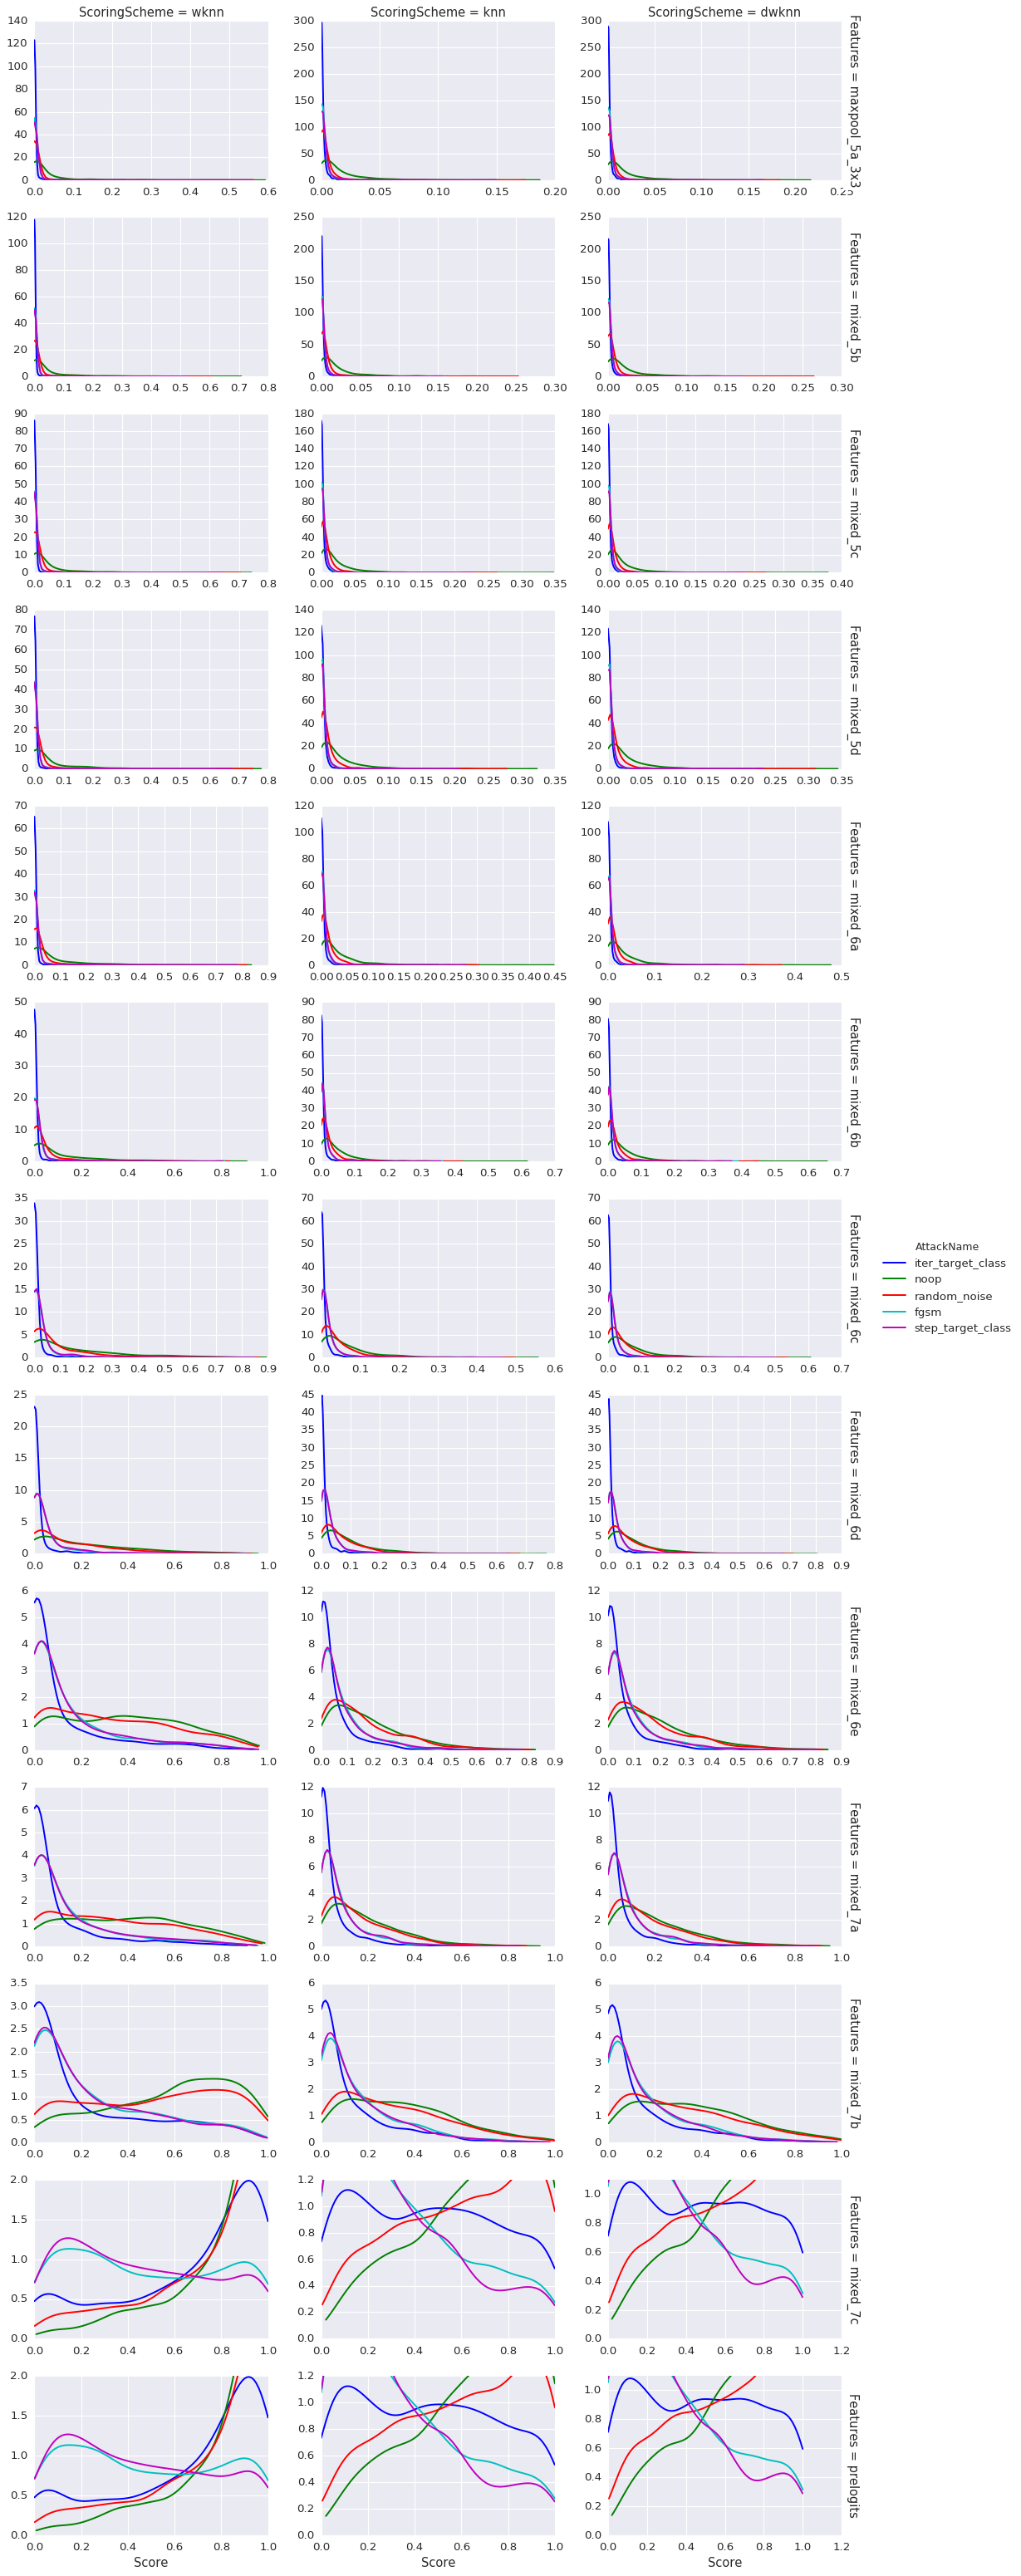

In [53]:
# for scheme, group in data.groupby('ScoringScheme'):
g = sns.FacetGrid(data[data['Pooling'] == 'avg_pool'].sort_values(by='Features'),
                  row='Features', col='ScoringScheme', hue='AttackName',
                  margin_titles=True, legend_out=True, aspect=1.5,
                  sharex=False, sharey=False)
g.map(sns.kdeplot, 'Score', cut=0).add_legend()

Let's plot the same thing with aggregated lines for adversarials and authentic inputs

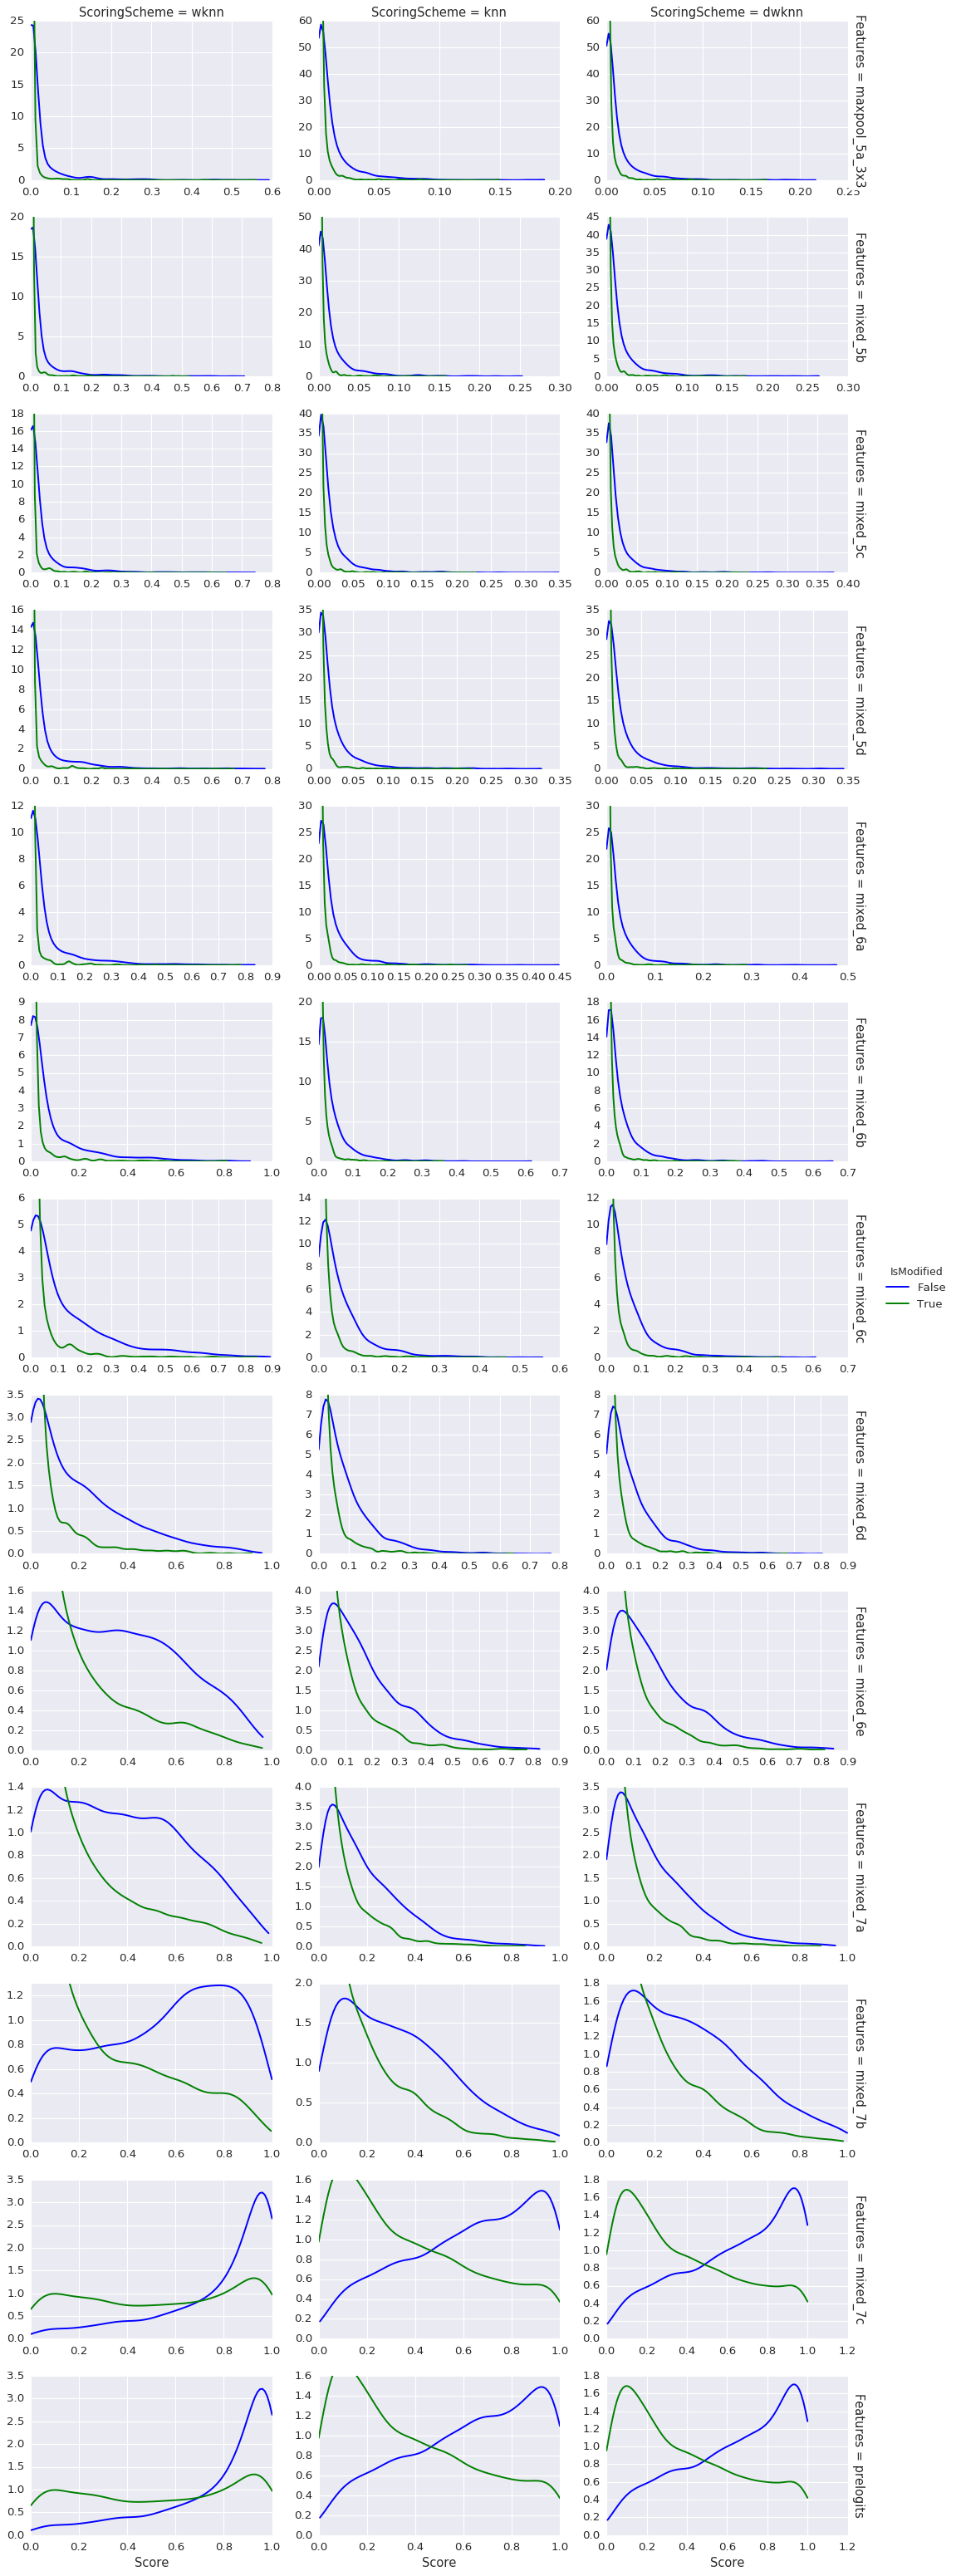

In [54]:
g = sns.FacetGrid(data[data['Pooling'] == 'avg_pool'].sort_values(by='Features'),
                  row='Features', col='ScoringScheme', hue='IsModified',
                  margin_titles=True, legend_out=True, aspect=1.5,
                  sharex=False, sharey=False)
g.map(sns.kdeplot, 'Score', cut=0).add_legend()

**NOTE**: Features layer below *Mixed_6e* hardly discren between authentic and modified images. The configuration **Mixed_7b + wknn** might seem the most promising, because it has the most notable differences between the density of authentic images (noop and random_noise) and modified ones (fgsm, step_target, iter_target).

We define a function to find the EER threshold and accuracy for a given set of scored images.

In [57]:
def eer(dataframe):
    y = 1 - dataframe['IsModified'] # higher the score, higher the authenticity.
    score = dataframe['Score']
    fpr, tpr, thresholds = metrics.roc_curve(y, score)
    fnr = 1 - tpr
    eer_idx = np.argmin(np.absolute(fnr - fpr))
    eer_threshold = thresholds[eer_idx]
    eer_accuracy = metrics.accuracy_score(y, score > eer_threshold)
    eer_f1score = metrics.f1_score(y, score > eer_threshold)
    return pd.Series({
            'EER Accuracy': 100 * eer_accuracy,
            #'EER Threshold': eer_threshold,
            'EER TPR': 100 * tpr[eer_idx],
            'EER TNR': 100 * (1-fpr)[eer_idx],
            'EER F1': 100 * eer_f1score
        })

In [58]:
a = data.groupby(['Features', 'ScoringScheme', 'Pooling']).apply(eer).unstack()
a = a.style.highlight_max(color='lightgray')
a
# eer(data[(data['Features'] == 'mixed_7b') & (data['ScoringScheme'] == 'wknn') ])

## Old Analysis

In [22]:
data = pd.read_csv('experiments.csv').sort_values(by='Feature')
data.tail()

,Auth_Accuracy,EER_Accuracy,Feature,Null_Accuracy,PreProc,Scoring,fgsm_Accuracy,iter_target_class_Accuracy,noop_Accuracy,random_noise_Accuracy,step_target_class_Accuracy
34,0.697857,0.6978,Mixed_7c,0.5148,PCA-256,wknn,0.827027,0.438579,0.875,0.928571,0.880450
35,0.700330,0.7002,Mixed_7c,0.5148,PCA-256,dwknn,0.791892,0.505584,0.800,0.887755,0.842475
37,0.697857,0.6978,PreLogits,0.5148,PCA-256,wknn,0.827027,0.438579,0.875,0.928571,0.880450
36,0.698269,0.6992,PreLogits,0.5148,PCA-256,knn,0.791892,0.507614,0.800,0.877551,0.841069
38,0.700330,0.7002,PreLogits,0.5148,PCA-256,dwknn,0.791892,0.505584,0.800,0.887755,0.842475


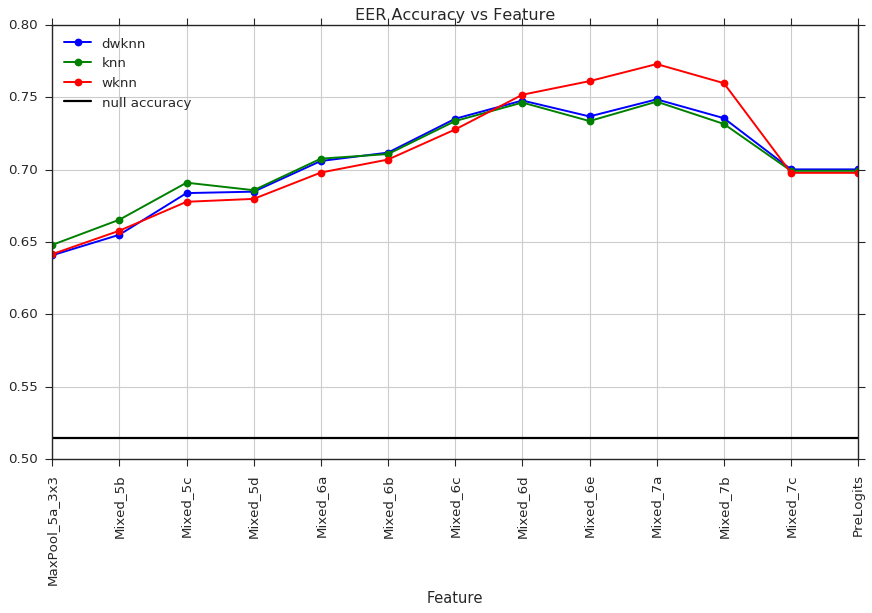

In [23]:
ax = None
for scoring, group in data.groupby('Scoring'):
    ax = group.plot(x='Feature', y='EER_Accuracy', label=scoring,
               title='EER Accuracy vs Feature', figsize=(13,7),
               grid=True, style='-o', ax=ax, rot=90)
    
_ = ax.set_xticks(range(len(group)))
_ = ax.set_xticklabels(group.Feature)

_ = ax.axhline(group.Null_Accuracy.values[0], color='k', label='null accuracy', linewidth=2)
_ = ax.legend(loc='best')
plt.savefig('report.pdf', bbox_inches='tight')

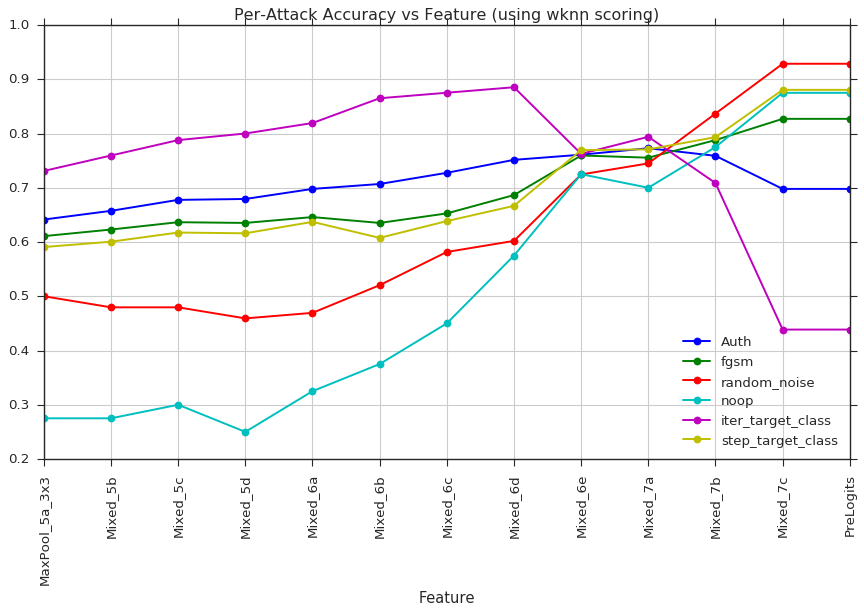

In [37]:
attacks = ['Auth', 'fgsm', 'random_noise', 'noop', 'iter_target_class', 'step_target_class']
ax = None
wknn_data = data[data['Scoring'] == 'wknn']
for attack in attacks:
    ax = wknn_data.plot(x='Feature', y=attack + '_Accuracy', label=attack,
               title='Per-Attack Accuracy vs Feature (using wknn scoring)', figsize=(13,7),
               grid=True, style='-o', ax=ax, rot=90)
    
_ = ax.set_xticks(range(len(wknn_data)))
_ = ax.set_xticklabels(wknn_data.Feature)

# _ = ax.axhline(wknn_data.Null_Accuracy.values[0], color='k', label='null accuracy', linewidth=2)
_ = ax.legend(loc='best')
# plt.savefig('report.pdf', bbox_inches='tight')

In [19]:
cdata = pd.read_csv('../output_dir/all_classification.csv')
cdata = cdata[cdata['DefenseName'] == 'base_inception_model']
cdata['IsAuth'] = cdata['PredictedLabel'] ==  cdata['TrueLabel']
for is_auth, group in cdata.groupby('IsAuth'):
    if is_auth:
        group.count()
    else:
        group.groupby('AttackName').count()['IsAuth']
        
2435/5000.0

AttackName
fgsm                 741
iter_target_class    977
noop                  39
random_noise          99
step_target_class    709
Name: IsAuth, dtype: int64

AttackName        2435
IsTargeted        2435
DefenseName       2435
ImageId           2435
PredictedLabel    2435
TrueLabel         2435
TargetClass       2435
IsAuth            2435
dtype: int64

0.487

# Misclassification Analysis

In [38]:
data = pd.read_csv('classification_stats.csv', names=['ImageURL', 'TrueLabelRank'])
rank = data.groupby('TrueLabelRank').count() * 100 / len(data)
rank.sort_values(by='ImageURL', ascending=False)

,ImageURL
TrueLabelRank,
0,48.52
1,6.94
2,4.00
3,2.18
4,1.94
5,1.76
9,1.10
7,1.08
8,1.08
